In [1]:
import os
import random
import numpy as np
import joblib
import torch
import torch.nn as nn

from environments import atari_environments

seed = 100

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

pygame 2.5.2 (SDL 2.28.3, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class mlp(nn.Module):

    def __init__(self):
        super(mlp,self).__init__()
        self.fc1=nn.Linear(5,3000)
        self.fc1_actv_fn=nn.Sigmoid()
        self.fc2=nn.Linear(3000,3000)
        self.fc2_actv_fn=nn.Sigmoid()
        self.fc3=nn.Linear(3000,300)
        self.fc3_actv_fn=nn.Sigmoid()
        self.out=nn.Linear(300,3)
        self.out_actv_fn=nn.Sigmoid()

    def forward(self,x):
        if ~isinstance(x,torch.Tensor):
            if isinstance(x,(float,list,tuple)):
                x = torch.tensor(x)
        x = self.fc1_actv_fn(self.fc1(x))
        x = self.fc2_actv_fn(self.fc2(x))
        x = self.fc3_actv_fn(self.fc3(x))
        x = self.out(x)
        x = self.out_actv_fn(x)
        return x

class cnn(nn.Module):

    def __init__(self):
        super(cnn,self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1,5,kernel_size=2,stride=1), # Input = 5 | Output = 5*4
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=1), # Input = 5*4 | Output = 5*3
            nn.Conv1d(5,15,kernel_size=1,stride=1), #  Input = 5*3 | 
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2,stride=1,padding=1), # Input = 15*3 | Output = 15*4
        )

        self.fc = nn.Sequential(
            nn.Linear(60,300),
            nn.Sigmoid(),
            nn.Linear(300,100),
            nn.Sigmoid(),
            nn.Linear(100,3),
            nn.Sigmoid()
        )

    def forward(self,x):
        if x.dim()==1:
            x = x.unsqueeze(dim=0)
        elif x.dim()==2:
            x = x.unsqueeze(dim=1)
        x = self.conv(x)
        if x.dim()==2:
            x = x.unsqueeze(dim=0)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x


In [3]:
def dqn_select_action(env,training_loop, max_epsilon, min_epsilon, epsilon_decay,dqn):
    epsilon= max(min_epsilon, max_epsilon - (max_epsilon-min_epsilon) * training_loop/epsilon_decay)
    n = random.random()
    if n <= epsilon:
        action_choice = random.randint(0,len(env.__ACTION_SPACE__)-1)
    else:
        dqn = dqn.eval()
        state = torch.tensor(env.observe())
        Q_est = dqn(state)
        action_choice = torch.argmax(Q_est).item()
    return action_choice,epsilon

In [4]:
def checkpoint_model(name,dqn,history,file_dir,file_name,epsilon_tuple,reward_tuple,alpha,gamma,no_epochs,batch_size,replay_buffer_size,
                     hits_epoch,rewards_epoch,lr):
    model = {
        "name":name,
        "Q-Network":dqn,
        "learning_rate":lr,
        "history":history,
        "PARAMS":{
            "epsilon": epsilon_tuple,
            "reward": reward_tuple,
            "alpha":alpha,
            "gamma":gamma,
            "no_epochs":no_epochs,
            "batch_size":batch_size,
            "replay_buffer_size":replay_buffer_size,
        },
        "PERFORMANCE":{
            "hits_epoch_slope":hits_epoch,
            "rewards_epoch_slope":rewards_epoch
        }
    }

    joblib.dump(model,file_dir+file_name)

In [11]:
env_params = {
    "HEIGHT":600,
    "WIDTH":840,
    "PADDLE_HEIGHT":100,
    "PADDLE_WIDTH":10,
    "BALL_SIZE":10,
    "BALL_SPEED":(random.choice([-7,7]),random.choice([-7,7])),
    "MISS_REWARD":-5,
    "HIT_REWARD":10,
    "PASSIVE_REWARD":1
}
env = atari_environments.pong_env(**env_params)

In [12]:
maximum_epsilon, minimum_epsilon, epsilon_decay_steps = 0.8,0.6,10000
alpha = 0.3
gamma = 0.1

prev_states = []
actions = []
next_states = []
rewards = []

train = True
training_loop = 0
last_training_step = 0
training_intervals = 400

no_epochs = 10000
no_epochs_per_epoch = 10
batch_size = 300
replay_buffer_size = 6000

In [13]:

model_name = "model12"

cycle = 0
hits = 0
total_rewards = 0

Online_DQN = cnn()
Target_DQN = cnn()
learning_rate = 1E-15
optimizer = torch.optim.Adam(Online_DQN.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

history = {
    "hit_ratio":[],
    "loss":[],
    "epsilon":[],
    "hits":[],
    "rewards":[]
}

env.reset()
while train==True:
    
    action,epsilon = dqn_select_action(env=env,training_loop=training_loop,max_epsilon=maximum_epsilon,\
                               min_epsilon=minimum_epsilon, epsilon_decay=epsilon_decay_steps,dqn=Online_DQN)

    prev_state, action, next_state, reward = env.step(action)

    if reward==env.HIT_REWARD or reward==env.MISS_REWARD:
        cycle += 1
        if reward==env.HIT_REWARD:
            hits += 1
    total_rewards += reward

    if len(prev_states)>=replay_buffer_size:
        random_drop =random.randint(0,replay_buffer_size-1)
        prev_states.pop(random_drop)
        actions.pop(random_drop)
        next_states.pop(random_drop)
        rewards.pop(random_drop)
    prev_states.append(prev_state)
    actions.append(action)
    next_states.append(next_state)
    rewards.append(reward)

    if training_loop%10==0 and len(prev_states)>=replay_buffer_size:
        Target_DQN.load_state_dict(Online_DQN.state_dict())

    if env.steps-last_training_step>=training_intervals and len(prev_states)>=replay_buffer_size:

        training_loop += 1

        batch_loss = 0
        for i in range(no_epochs_per_epoch):

            indices = list(np.random.random_integers(0,replay_buffer_size-1,batch_size))
            
            last_training_step = env.steps
            prev_states_ = torch.tensor(prev_states)[indices]
            actions_ = torch.tensor(actions)[indices]
            next_states_ = torch.tensor(next_states)[indices]
            rewards_ = torch.tensor(rewards)[indices]

            Online_DQN = Online_DQN.eval()
            Target_DQN = Target_DQN.eval()
            Q = Online_DQN(prev_states_)
            Qnsa = Target_DQN(next_states_)
            Qt = (torch.max(Qnsa, dim=1))[0]
            Qt = rewards_ + Qt
            y = Qnsa.clone()
                
            for i in range(Q.size()[0]):
                y[i,actions_[i]] = Qt[i]

            Q = Q.requires_grad_(True)

            Online_DQN = Online_DQN.train()

            loss = loss_fn(Q,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss += loss
        loss = batch_loss/no_epochs_per_epoch

        print("-------------------------------------------------------------------------------------")
        print(f"{training_loop} => performance: {hits/cycle:.2f} | loss: {loss.item():.2f} | epsilon: {epsilon:.2f}")
        print(f"hits: {hits} | no_cycles: {cycle} | rewards: {total_rewards}" )
        history["hit_ratio"].append(hits/cycle)
        history["loss"].append(loss)
        history["epsilon"].append(epsilon)
        history["hits"].append(hits)
        history["rewards"].append(total_rewards)
    
    if training_loop==no_epochs:
        Target_DQN.load_state_dict(Online_DQN.state_dict())
        train = False

C:\Users\peTron\AppData\Local\Temp\ipykernel_11536\1311666831.py:53: DeprecationWarning: This function is deprecated. Please call randint(0, 499 + 1) instead
  indices = list(np.random.random_integers(0,replay_buffer_size-1,batch_size))


-------------------------------------------------------------------------------------
1 => performance: 0.00 | loss: 0.42 | epsilon: 0.80
hits: 0 | no_cycles: 3 | rewards: 482
-------------------------------------------------------------------------------------
2 => performance: 0.00 | loss: 0.35 | epsilon: 0.80
hits: 0 | no_cycles: 3 | rewards: 582
-------------------------------------------------------------------------------------
3 => performance: 0.00 | loss: 0.38 | epsilon: 0.80
hits: 0 | no_cycles: 4 | rewards: 676
-------------------------------------------------------------------------------------
4 => performance: 0.00 | loss: 0.38 | epsilon: 0.80
hits: 0 | no_cycles: 4 | rewards: 776
-------------------------------------------------------------------------------------
5 => performance: 0.20 | loss: 0.38 | epsilon: 0.80
hits: 1 | no_cycles: 5 | rewards: 885
-------------------------------------------------------------------------------------
6 => performance: 0.20 | loss: 0.4

Text(0.5, 1.0, 'Rewards VS Cycle')

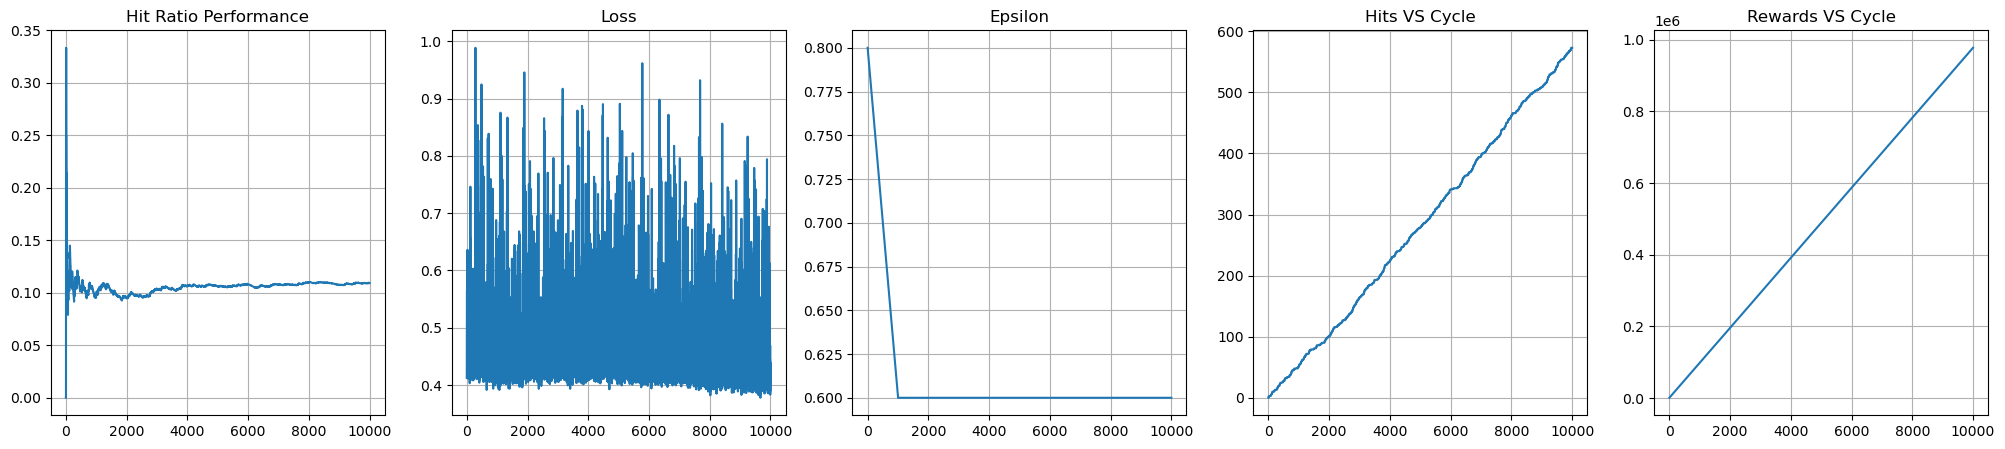

In [8]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,5,figsize=(25,5))

ax.flatten()[0].plot(np.linspace(0,no_epochs,no_epochs),history["hit_ratio"])
ax.flatten()[1].plot(np.linspace(0,no_epochs,no_epochs),[loss_.detach().numpy() for loss_ in history["loss"]])
ax.flatten()[2].plot(np.linspace(0,no_epochs,no_epochs),history["epsilon"])
ax.flatten()[3].plot(np.linspace(0,no_epochs,no_epochs),history["hits"])
ax.flatten()[4].plot(np.linspace(0,no_epochs,no_epochs),history["rewards"])

for i in range(5):
    ax.flatten()[i].grid()

ax.flatten()[0].set_title("Hit Ratio Performance")
ax.flatten()[1].set_title("Loss")
ax.flatten()[2].set_title("Epsilon")
ax.flatten()[3].set_title("Hits VS Cycle")
ax.flatten()[4].set_title("Rewards VS Cycle")

In [9]:
checkpoint_model(model_name,Online_DQN,history,"DQN_training_sessions/",model_name+".sav",
                 (minimum_epsilon,maximum_epsilon,epsilon_decay_steps),(env.HIT_REWARD,env.MISS_REWARD,env.PASSIVE_REWARD),
                 alpha,gamma,no_epochs,batch_size,replay_buffer_size,history["hits"][-1]/no_epochs,history["rewards"][-1]/no_epochs,
                 learning_rate
                 )

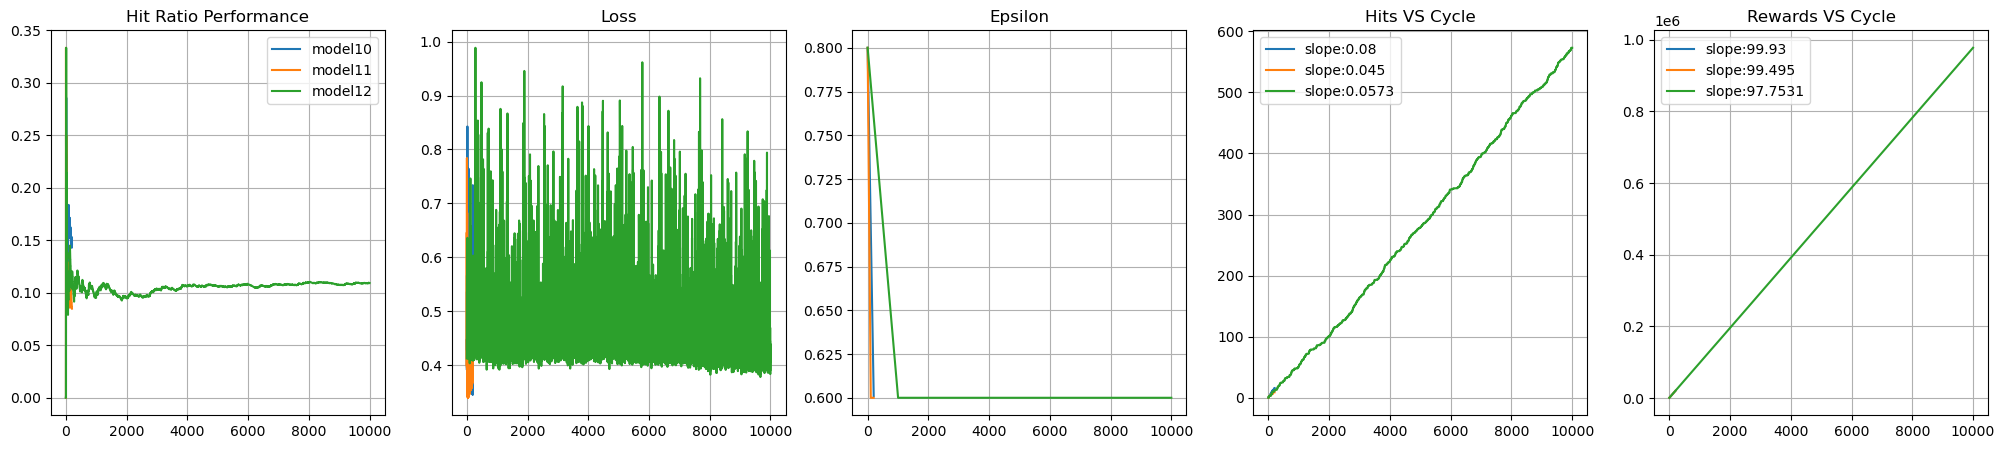

In [10]:
training_dir = "DQN_training_sessions/"
training_sessions = []
sessions_name = []
files = os.listdir(training_dir)
dqn_exclude = ["hit_cycle_0.055.sav","hit_cycle_0.075.sav","model3.sav","model4.sav","model5.sav","model6.sav","model7.sav","model8.sav",
                "model9.sav"]
for exclude in dqn_exclude:
    files.remove(exclude)
for file in files:
    training_sessions.append(joblib.load(training_dir+file))
    sessions_name.append(training_sessions[-1]["name"])

fig,ax = plt.subplots(1,5,figsize=(25,5))

for train in training_sessions:
    ax.flatten()[0].plot(np.linspace(0,train["PARAMS"]["no_epochs"],train["PARAMS"]["no_epochs"]),train["history"]["hit_ratio"],label=train["name"])
    ax.flatten()[1].plot(np.linspace(0,train["PARAMS"]["no_epochs"],train["PARAMS"]["no_epochs"]),[loss_.detach().numpy() for loss_ in train["history"]["loss"]])
    ax.flatten()[2].plot(np.linspace(0,train["PARAMS"]["no_epochs"],train["PARAMS"]["no_epochs"]),train["history"]["epsilon"])
    ax.flatten()[3].plot(np.linspace(0,train["PARAMS"]["no_epochs"],train["PARAMS"]["no_epochs"]),train["history"]["hits"],label=f"slope:{train["PERFORMANCE"]["hits_epoch_slope"]}")
    ax.flatten()[4].plot(np.linspace(0,train["PARAMS"]["no_epochs"],train["PARAMS"]["no_epochs"]),train["history"]["rewards"],label=f"slope:{train["PERFORMANCE"]["rewards_epoch_slope"]}")

    for i in range(5):
        ax.flatten()[i].grid()

    ax.flatten()[0].set_title("Hit Ratio Performance")
    ax.flatten()[1].set_title("Loss")
    ax.flatten()[2].set_title("Epsilon")
    ax.flatten()[3].set_title("Hits VS Cycle")
    ax.flatten()[4].set_title("Rewards VS Cycle")
ax.flatten()[0].legend()
ax.flatten()[3].legend()
ax.flatten()[4].legend()

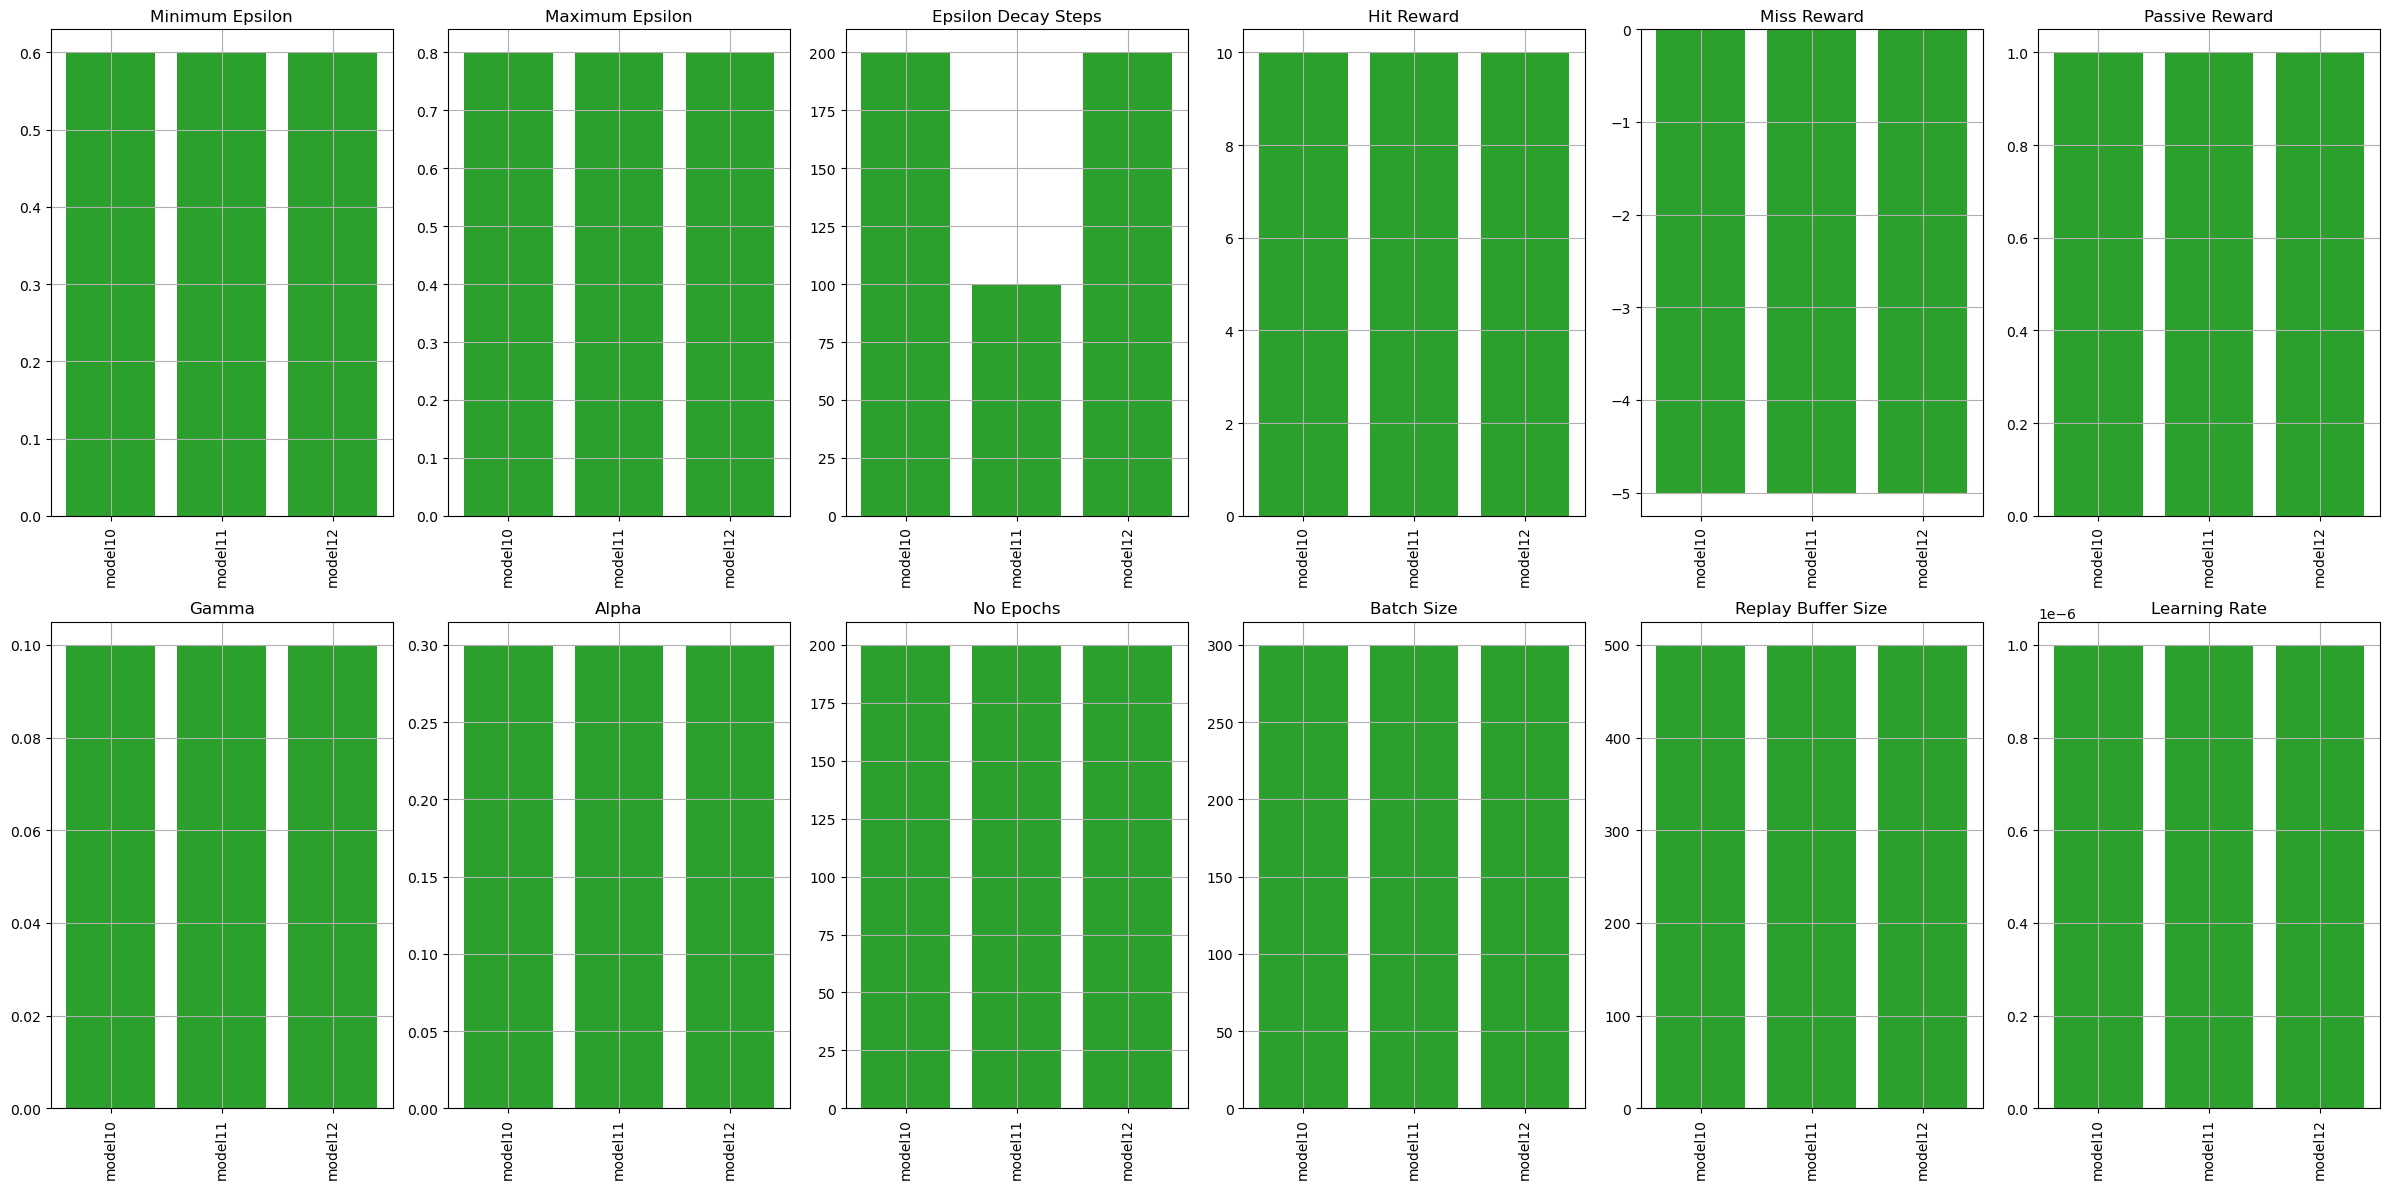

In [55]:
fig, ax = plt.subplots(2,6,figsize=(24,12))

min_epsilon = [train["PARAMS"]["epsilon"][0] for train in training_sessions]
max_epsilon = [train["PARAMS"]["epsilon"][1] for train in training_sessions]
eps_decay_steps = [train["PARAMS"]["epsilon"][2] for train in training_sessions]
hit_reward = [train["PARAMS"]["reward"][0] for train in training_sessions]
miss_reward = [train["PARAMS"]["reward"][1] for train in training_sessions]
passive_reward = [train["PARAMS"]["reward"][2] for train in training_sessions]
gamma_ = [train["PARAMS"]["gamma"] for train in training_sessions]
alpha_ = [train["PARAMS"]["alpha"] for train in training_sessions]
no_epochs_ = [train["PARAMS"]["no_epochs"] for train in training_sessions]
batch_size_ = [train["PARAMS"]["batch_size"] for train in training_sessions]
replay_size_ = [train["PARAMS"]["replay_buffer_size"] for train in training_sessions]
learning_rate_ = [train["learning_rate"] for train in training_sessions]


for train in training_sessions:
    for p,param in enumerate([min_epsilon,max_epsilon,eps_decay_steps,hit_reward,miss_reward,passive_reward,gamma_,alpha_,no_epochs_,batch_size,\
        replay_size_,learning_rate_]):
        ax.flatten()[p].bar(sessions_name,param,label=sessions_name)
        ax.flatten()[p].tick_params(axis='x', labelrotation=90)
        ax.flatten()[p].grid()

for t,title in enumerate(["Minimum Epsilon","Maximum Epsilon","Epsilon Decay Steps","Hit Reward","Miss Reward","Passive Reward",\
    "Gamma","Alpha","No Epochs","Batch Size","Replay Buffer Size","Learning Rate"]):
    ax.flatten()[t].set_title(title)

fig.tight_layout()


In [56]:
sessions_name

['model10', 'model11', 'model12']

In [57]:
[train["Q-Network"] for train in training_sessions]

[mlp(
   (fc1): Linear(in_features=5, out_features=3000, bias=True)
   (fc1_actv_fn): Sigmoid()
   (fc2): Linear(in_features=3000, out_features=3000, bias=True)
   (fc2_actv_fn): Sigmoid()
   (fc3): Linear(in_features=3000, out_features=300, bias=True)
   (fc3_actv_fn): Sigmoid()
   (out): Linear(in_features=300, out_features=3, bias=True)
   (out_actv_fn): Sigmoid()
 ),
 mlp(
   (fc1): Linear(in_features=5, out_features=3000, bias=True)
   (fc1_actv_fn): Sigmoid()
   (fc2): Linear(in_features=3000, out_features=3000, bias=True)
   (fc2_actv_fn): Sigmoid()
   (fc3): Linear(in_features=3000, out_features=300, bias=True)
   (fc3_actv_fn): Sigmoid()
   (out): Linear(in_features=300, out_features=3, bias=True)
   (out_actv_fn): Sigmoid()
 ),
 cnn(
   (conv): Sequential(
     (0): Conv1d(1, 5, kernel_size=(2,), stride=(1,))
     (1): ReLU()
     (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
     (3): Conv1d(5, 15, kernel_size=(1,), stride=(1,))
     (4): Re

In [72]:
training_sessions[0]

{'name': 'model10',
 'Q-Network': mlp(
   (fc1): Linear(in_features=5, out_features=3000, bias=True)
   (fc1_actv_fn): Sigmoid()
   (fc2): Linear(in_features=3000, out_features=3000, bias=True)
   (fc2_actv_fn): Sigmoid()
   (fc3): Linear(in_features=3000, out_features=300, bias=True)
   (fc3_actv_fn): Sigmoid()
   (out): Linear(in_features=300, out_features=3, bias=True)
   (out_actv_fn): Sigmoid()
 ),
 'learning_rate': 1e-12,
 'history': {'hit_ratio': [0.0,
   0.0,
   0.0,
   0.25,
   0.25,
   0.2,
   0.2,
   0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666,
   0.2857142857142857,
   0.2857142857142857,
   0.25,
   0.25,
   0.2222222222222222,
   0.2222222222222222,
   0.2222222222222222,
   0.2,
   0.18181818181818182,
   0.18181818181818182,
   0.16666666666666666,
   0.23076923076923078,
   0.23076923076923078,
   0.23076923076923078,
   0.21428571428571427,
   0.21428571428571427,
   0.2,
   0.2,
   0.1875,
   0.17647058823529413,
   0.17647058823529413,
   0.1